## 어제 오른 내 주식, 과연 내일은?

## STEP 1 : 시계열 데이터 준비


In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()
ts.tail()

Date
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, dtype: float64

### Yahoo finance api 사용하여 주가 데이터 불러오기

In [3]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data = yf.download('SOXL', start='2020-01-01', end='2024-02-28')

[*********************100%%**********************]  1 of 1 completed


In [6]:
data.head()
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-21,35.110001,36.150002,34.580002,36.139999,36.139999,65483300
2024-02-22,40.450001,42.049999,39.869999,41.419998,41.419998,96865500
2024-02-23,42.139999,42.680000,39.410000,40.169998,40.169998,68430000
2024-02-26,41.220001,41.799999,40.400002,41.209999,41.209999,49475100
2024-02-27,41.810001,42.160000,40.779999,41.110001,41.110001,48124600


In [7]:
ts = data['Close']
ts

Date
2020-01-02    19.464001
2020-01-03    18.412666
2020-01-06    17.828667
2020-01-07    18.747999
2020-01-08    18.789333
                ...    
2024-02-21    36.139999
2024-02-22    41.419998
2024-02-23    40.169998
2024-02-26    41.209999
2024-02-27    41.110001
Name: Close, Length: 1045, dtype: float64

## STEP 2 : 각종 전처리 수행


In [8]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.731218
p-value                           0.415104
#Lags Used                        1.000000
Number of Observations Used    1043.000000
Critical Value (1%)              -3.436635
Critical Value (5%)              -2.864315
Critical Value (10%)             -2.568248
dtype: float64


In [11]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2020-01-02    2.968567
2020-01-03    2.913039
2020-01-06    2.880808
2020-01-07    2.931087
2020-01-08    2.933289
                ...   
2024-02-21    3.587400
2024-02-22    3.723764
2024-02-23    3.693120
2024-02-26    3.718681
2024-02-27    3.716251
Name: Close, Length: 1045, dtype: float64

## STEP 3 : 시계열 안정성 분석
1. 정성적 그래프 분석
2. 정량적 Augmented Dicky-Fuller Test
3. 시계열 분해(Time Series Decomposition)
4. Residual 안정성 확인



**1. 정성적 그래프 분석**

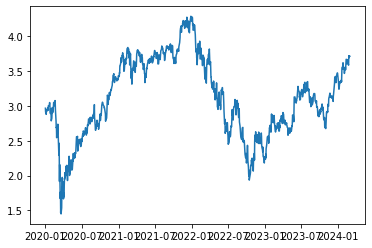

In [12]:
# 정성적 그래프 분석
plt.plot(ts_log)


#### 그래프를 보면 트랜드가 있고 비정상성을 확인

In [13]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

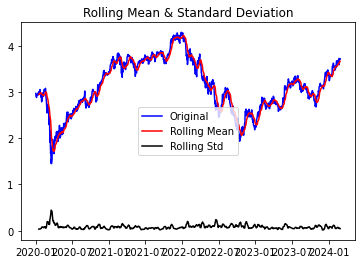

In [14]:
plot_rolling_statistics(ts_log, window=12)

**2. 정량적 Augmented Dicky-Fuller Test**


In [15]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.706039
p-value                           0.428004
#Lags Used                        9.000000
Number of Observations Used    1035.000000
Critical Value (1%)              -3.436684
Critical Value (5%)              -2.864337
Critical Value (10%)             -2.568259
dtype: float64


### log를 씌운 것이나 원래 가격이나 p-value가 비슷. 오히려 log가 더 p-value가 높음

**3. 시계열 분해(Time Series Decomposition)**

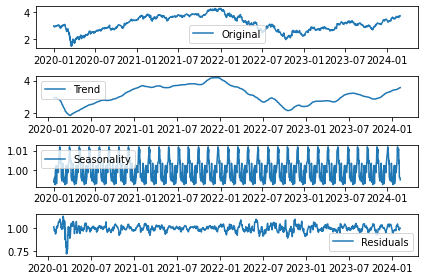

In [16]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**4. Residual 안정성 확인**

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.883668e+00
p-value                        3.712561e-17
#Lags Used                     2.100000e+01
Number of Observations Used    9.930000e+02
Critical Value (1%)           -3.436953e+00
Critical Value (5%)           -2.864455e+00
Critical Value (10%)          -2.568322e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

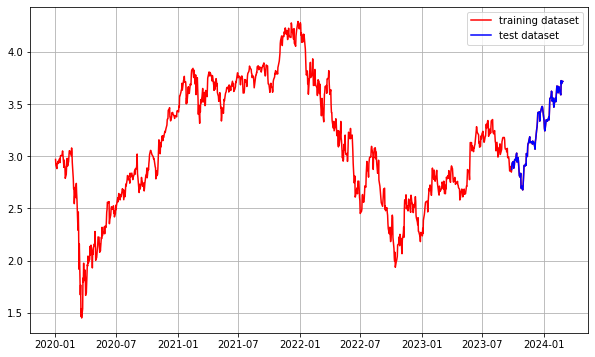

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


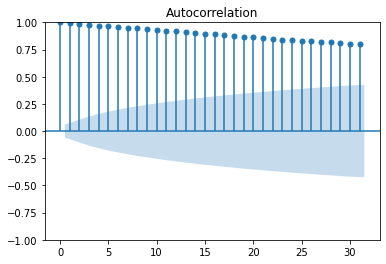

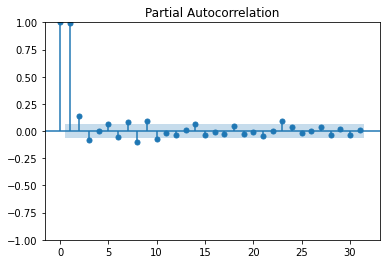

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.057600e+01
p-value                        7.103138e-19
#Lags Used                     8.000000e+00
Number of Observations Used    1.035000e+03
Critical Value (1%)           -3.436684e+00
Critical Value (5%)           -2.864337e+00
Critical Value (10%)          -2.568259e+00
dtype: float64


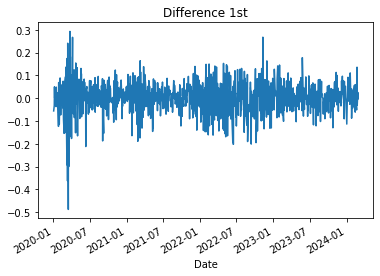

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.060897e+01
p-value                        5.901418e-19
#Lags Used                     2.200000e+01
Number of Observations Used    1.020000e+03
Critical Value (1%)           -3.436777e+00
Critical Value (5%)           -2.864378e+00
Critical Value (10%)          -2.568281e+00
dtype: float64


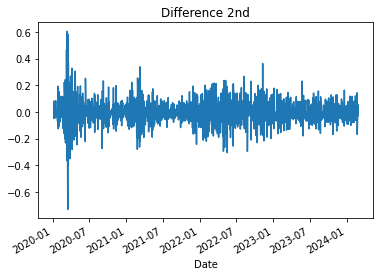

In [21]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트


In [22]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  940
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1149.528
Date:                Sat, 02 Mar 2024   AIC                          -2289.057
Time:                        14:09:57   BIC                          -2264.827
Sample:                             0   HQIC                         -2279.820
                                - 940                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0499      0.324      9.411      0.000       2.415       3.685
ar.L1          0.5444      0.121      4.509      0.000       0.308       0.781
ar.L2          0.4457      0.119      3.744      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


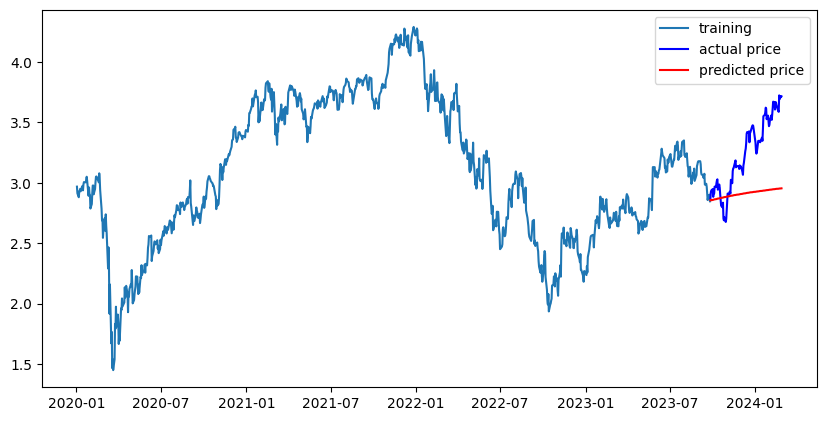

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  114.94212156483509
MAE:  8.427864053594144
RMSE:  10.721106359179313
MAPE: 27.47%


## MAPE 최적화 하기

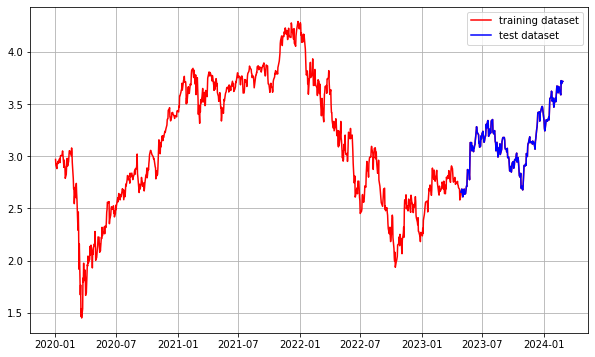

In [56]:
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [91]:
from pmdarima import auto_arima

# Since d=0 has been found to be optimal manually, we set d=0 explicitly
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              d=0,  # Explicitly setting d=0 based on manual analysis
                              seasonal=False,  # Assuming non-seasonality for stock price data
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1982.232, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4297.741, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3167.181, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1987.370, Time=1.54 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1986.665, Time=1.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1987.465, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1988.135, Time=0.87 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2242.810, Time=0.72 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1988.249, Time=0.62 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1414.128, Time=0.76 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1988.918, Time=2.83 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-2017.355, Time=2.88 sec
 ARIMA(3,0,2)(0,0,0)[0]            

In [92]:
# 새로운 parameter로 다시 모델링
model = ARIMA(train_data, order=(3,0,2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  836
Model:                 ARIMA(3, 0, 2)   Log Likelihood                1018.826
Date:                Sat, 02 Mar 2024   AIC                          -2023.652
Time:                        15:57:13   BIC                          -1990.551
Sample:                             0   HQIC                         -2010.963
                                - 836                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9817      0.379      7.858      0.000       2.238       3.725
ar.L1         -0.7516      0.033    -22.811      0.000      -0.816      -0.687
ar.L2          0.8414      0.016     54.158      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


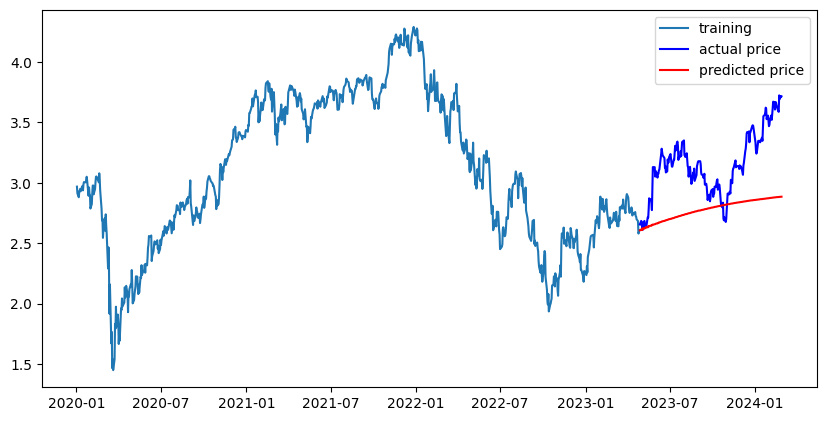

In [93]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  96.97591719307862
MAE:  8.027247057968575
RMSE:  9.847635106617153
MAPE: 29.64%


## AIRMA 모델로 더 이상 MAPE를 낮출 수 없음
## LSTM 모델 사용

In [98]:
df = yf.download('SOXL', start='2020-01-01', end='2024-02-28')

[*********************100%%**********************]  1 of 1 completed


In [99]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming `df` is your DataFrame and 'Close' is the column with stock prices
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predicting and inverse transforming the predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


Epoch 1/100
24/24 [==============================] - 4s 47ms/step - loss: 0.0243 - val_loss: 9.4849e-04
Epoch 2/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 4.0289e-04
Epoch 3/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0031 - val_loss: 4.1472e-04
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 3.5474e-04
Epoch 5/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 3.9821e-04
Epoch 6/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0030 - val_loss: 3.7251e-04
Epoch 7/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0029 - val_loss: 3.6320e-04
Epoch 8/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 3.6569e-04
Epoch 9/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 3.5527e-04
Epoch 10/100
24/24 [==============================] - 0s 20ms/st

In [100]:
def calculate_mape(true_values, predictions):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    
    Parameters:
    - true_values: the actual values.
    - predictions: the predicted values from the model.
    
    Returns:
    - MAPE as a percentage.
    """
    true_values, predictions = np.array(true_values), np.array(predictions)
    return np.mean(np.abs((true_values - predictions) / true_values)) * 100

# Assuming `y_test` is unscaled actual values and you've predicted `predicted_stock_price`:
# First, ensure `y_test` is reshaped or sliced to match the dimensions of `predicted_stock_price`
# If `y_test` was scaled, inverse transform it back to its original scale to match `predicted_stock_price`
true_values_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE
mape = calculate_mape(true_values_rescaled, predicted_stock_price)
print(f"MAPE: {mape}%")


MAPE: 4.352904706986151%


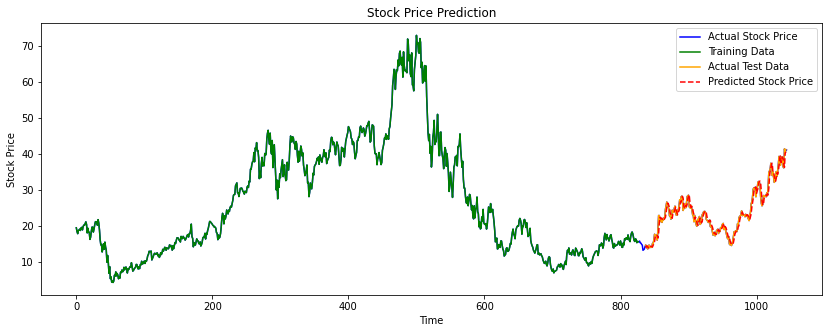

In [106]:
import matplotlib.pyplot as plt

# Assuming 'df' and 'Close' as before, and that 'true_values_rescaled' and 'predicted_stock_price'
# have been correctly calculated

plt.figure(figsize=(14, 5))
plt.plot(df['Close'].reset_index(drop=True), color='blue', label='Actual Stock Price')

# Assuming 'train_size' is the number of samples in your training set
# And 'seq_length' was used in preparing sequences for the LSTM
# Adjust the train and test data plots to align with the prepared data
plt.plot(scaler.inverse_transform(X_train[:, 0]), color='green', label='Training Data')

# The predicted_stock_price might need to be aligned with the test data's actual indices
# Let's assume test_data_range needs to be adjusted for seq_length and any additional offsets
adjusted_test_data_range = np.arange(train_size + seq_length, train_size + seq_length + len(predicted_stock_price))

plt.plot(adjusted_test_data_range, true_values_rescaled, color='orange', label='Actual Test Data')
plt.plot(adjusted_test_data_range, predicted_stock_price, color='red', linestyle='--', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


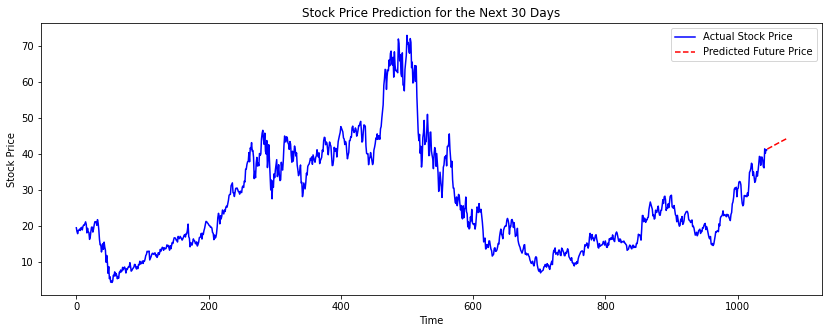

In [109]:
# Extend the actual stock price plot with the predictions
plt.figure(figsize=(14, 5))

# Plot the actual stock prices
plt.plot(df['Close'].reset_index(drop=True), color='blue', label='Actual Stock Price')

# Calculate the starting index for predictions
prediction_start = len(df['Close'])

# Create an index array for the predictions
predicted_index = np.arange(prediction_start, prediction_start + len(predicted_prices_scaled))

# Plot the predictions
plt.plot(predicted_index, predicted_prices_scaled, color='red', linestyle='--', label='Predicted Future Price')

plt.title('Stock Price Prediction for the Next 30 Days')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### 다른 종목 예측 1

In [6]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.3 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 81.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 20.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp39-cp39-linux_x86_64.whl size=297193 sha256=501a97afa7bdee2354f22e2bbb682cc1953e0902c3460250b861bc737d4ca5bd
  Stored in directory: /aiffel/.cache/pip/wh

In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df = yf.download('YINN', start='2020-01-01', end='2024-03-02')

[*********************100%%**********************]  1 of 1 completed


In [39]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,464.200012,480.000000,464.200012,479.600006,451.727844,139470
2020-01-03,453.000000,460.399994,449.200012,450.200012,424.036407,141580
2020-01-06,450.000000,456.000000,449.000000,455.600006,429.122498,68740
2020-01-07,453.799988,454.600006,449.200012,452.200012,425.920166,62595
2020-01-08,442.600006,458.399994,440.799988,451.799988,425.543365,156180
...,...,...,...,...,...,...
2024-02-26,19.450001,19.840000,19.260000,19.299999,19.299999,7359000
2024-02-27,20.180000,20.350000,20.030001,20.240000,20.240000,8805500
2024-02-28,18.920000,18.920000,18.180000,18.209999,18.209999,9717900


In [14]:
ts = data['Close']
ts

Date
2020-01-02    479.600006
2020-01-03    450.200012
2020-01-06    455.600006
2020-01-07    452.200012
2020-01-08    451.799988
                 ...    
2024-02-26     19.299999
2024-02-27     20.240000
2024-02-28     18.209999
2024-02-29     18.040001
2024-03-01     19.120001
Name: Close, Length: 1048, dtype: float64

In [16]:
ts = ts.interpolate(method='time')

In [17]:
ts

Date
2020-01-02    479.600006
2020-01-03    450.200012
2020-01-06    455.600006
2020-01-07    452.200012
2020-01-08    451.799988
                 ...    
2024-02-26     19.299999
2024-02-27     20.240000
2024-02-28     18.209999
2024-02-29     18.040001
2024-03-01     19.120001
Name: Close, Length: 1048, dtype: float64

In [18]:
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

In [19]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [20]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.656270
p-value                           0.453772
#Lags Used                        6.000000
Number of Observations Used    1041.000000
Critical Value (1%)              -3.436647
Critical Value (5%)              -2.864320
Critical Value (10%)             -2.568250
dtype: float64


In [22]:
import numpy as np
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2020-01-02    6.172952
2020-01-03    6.109692
2020-01-06    6.121615
2020-01-07    6.114125
2020-01-08    6.113240
                ...   
2024-02-26    2.960105
2024-02-27    3.007661
2024-02-28    2.901971
2024-02-29    2.892592
2024-03-01    2.950735
Name: Close, Length: 1048, dtype: float64

In [23]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.361429
p-value                           0.916342
#Lags Used                        6.000000
Number of Observations Used    1041.000000
Critical Value (1%)              -3.436647
Critical Value (5%)              -2.864320
Critical Value (10%)             -2.568250
dtype: float64


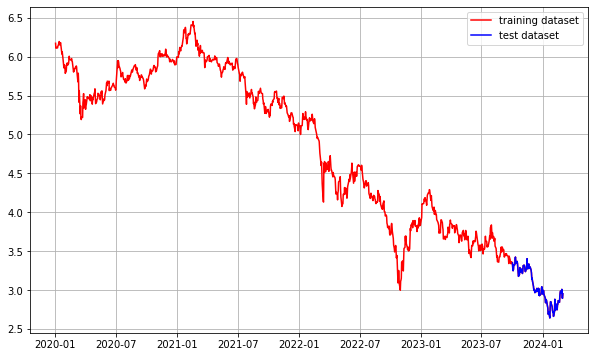

In [24]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [34]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  943
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1301.996
Date:                Sun, 03 Mar 2024   AIC                          -2593.992
Time:                        13:47:11   BIC                          -2569.752
Sample:                             0   HQIC                         -2584.753
                                - 943                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0627      8.130     -0.008      0.994     -15.998      15.873
ar.L2          0.1035      3.204      0.032      0.974      -6.176       6.383
ma.L1         -0.0363      8.134     -0.004      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


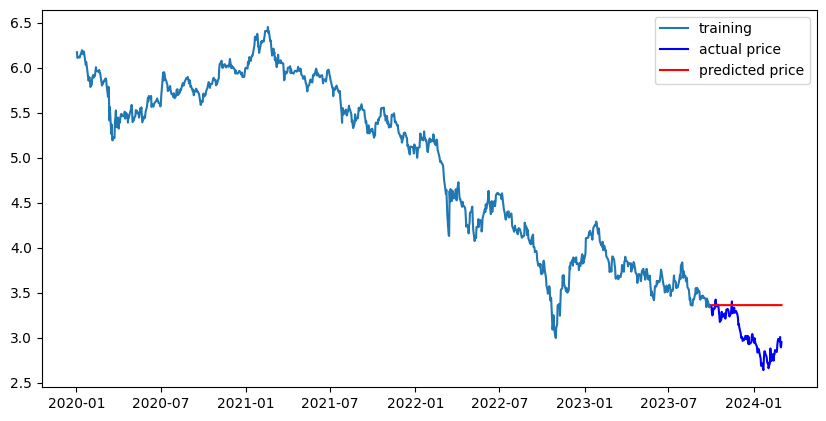

In [35]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  74.6738000465836
MAE:  7.369466973081809
RMSE:  8.641400352175774
MAPE: 40.49%


In [40]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming `df` is your DataFrame and 'Close' is the column with stock prices
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predicting and inverse transforming the predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


Epoch 1/100
24/24 [==============================] - 5s 44ms/step - loss: 0.0425 - val_loss: 0.0043
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 9.1071e-04
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 8.8177e-05
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 1.0515e-04
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 1.3222e-04
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 1.8322e-04
Epoch 7/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 8.5954e-05
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 8.4736e-05
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 8.7412e-05
Epoch 10/100
24/24 [==============================] - 0s 17ms/step -

In [41]:
def calculate_mape(true_values, predictions):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    
    Parameters:
    - true_values: the actual values.
    - predictions: the predicted values from the model.
    
    Returns:
    - MAPE as a percentage.
    """
    true_values, predictions = np.array(true_values), np.array(predictions)
    return np.mean(np.abs((true_values - predictions) / true_values)) * 100

# Assuming `y_test` is unscaled actual values and you've predicted `predicted_stock_price`:
# First, ensure `y_test` is reshaped or sliced to match the dimensions of `predicted_stock_price`
# If `y_test` was scaled, inverse transform it back to its original scale to match `predicted_stock_price`
true_values_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE
mape = calculate_mape(true_values_rescaled, predicted_stock_price)
print(f"MAPE: {mape}%")


MAPE: 5.511195558219939%


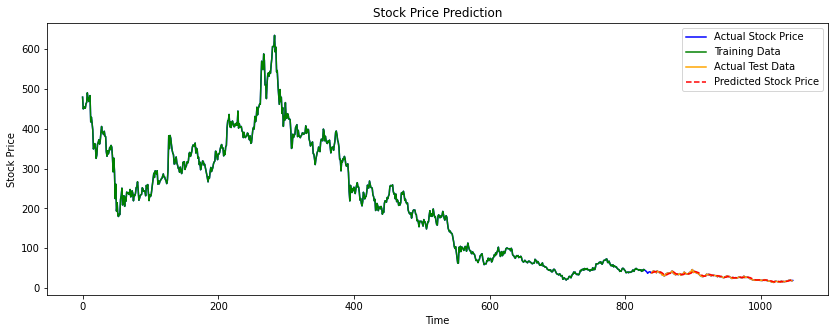

In [42]:
import matplotlib.pyplot as plt

# Assuming 'df' and 'Close' as before, and that 'true_values_rescaled' and 'predicted_stock_price'
# have been correctly calculated

plt.figure(figsize=(14, 5))
plt.plot(df['Close'].reset_index(drop=True), color='blue', label='Actual Stock Price')

# Assuming 'train_size' is the number of samples in your training set
# And 'seq_length' was used in preparing sequences for the LSTM
# Adjust the train and test data plots to align with the prepared data
plt.plot(scaler.inverse_transform(X_train[:, 0]), color='green', label='Training Data')

# The predicted_stock_price might need to be aligned with the test data's actual indices
# Let's assume test_data_range needs to be adjusted for seq_length and any additional offsets
adjusted_test_data_range = np.arange(train_size + seq_length, train_size + seq_length + len(predicted_stock_price))

plt.plot(adjusted_test_data_range, true_values_rescaled, color='orange', label='Actual Test Data')
plt.plot(adjusted_test_data_range, predicted_stock_price, color='red', linestyle='--', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [44]:
df = yf.download('LABU', start='2020-01-01', end='2024-03-02')

[*********************100%%**********************]  1 of 1 completed


In [45]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1176.000000,1176.599976,1095.599976,1129.000000,1124.612427,92215
2020-01-03,1080.000000,1111.619995,1059.680054,1083.400024,1079.189697,85155
2020-01-06,1051.400024,1111.800049,1030.000000,1111.000000,1106.682495,93810
2020-01-07,1119.599976,1130.000000,1068.800049,1115.599976,1111.264526,69195
2020-01-08,1109.000000,1174.400024,1101.800049,1161.400024,1156.886597,98405
...,...,...,...,...,...,...
2024-02-26,136.759995,149.250000,136.110001,148.440002,148.440002,2631900
2024-02-27,159.699997,175.399994,155.449997,174.119995,174.119995,5314900
2024-02-28,170.429993,176.990005,164.830002,166.479996,166.479996,3231300


In [46]:
ts = df['Close']
ts

Date
2020-01-02    1129.000000
2020-01-03    1083.400024
2020-01-06    1111.000000
2020-01-07    1115.599976
2020-01-08    1161.400024
                 ...     
2024-02-26     148.440002
2024-02-27     174.119995
2024-02-28     166.479996
2024-02-29     151.539993
2024-03-01     166.050003
Name: Close, Length: 1048, dtype: float64

In [47]:
ts = ts.interpolate(method='time')

In [48]:
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

In [49]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.414544
p-value                           0.575284
#Lags Used                       21.000000
Number of Observations Used    1026.000000
Critical Value (1%)              -3.436740
Critical Value (5%)              -2.864361
Critical Value (10%)             -2.568272
dtype: float64


In [50]:
import numpy as np
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2020-01-02    7.029088
2020-01-03    6.987860
2020-01-06    7.013016
2020-01-07    7.017148
2020-01-08    7.057381
                ...   
2024-02-26    5.000181
2024-02-27    5.159745
2024-02-28    5.114875
2024-02-29    5.020850
2024-03-01    5.112289
Name: Close, Length: 1048, dtype: float64

In [51]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.975665
p-value                           0.762036
#Lags Used                        1.000000
Number of Observations Used    1046.000000
Critical Value (1%)              -3.436617
Critical Value (5%)              -2.864307
Critical Value (10%)             -2.568243
dtype: float64


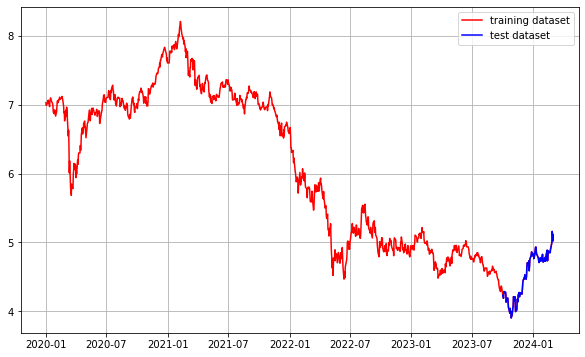

In [52]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [53]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  943
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1152.374
Date:                Sun, 03 Mar 2024   AIC                          -2294.748
Time:                        13:55:58   BIC                          -2270.508
Sample:                             0   HQIC                         -2285.509
                                - 943                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5502      1.240     -0.444      0.657      -2.981       1.880
ar.L2         -0.2140      0.675     -0.317      0.751      -1.538       1.110
ma.L1          0.4870      1.236      0.394      0.6

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


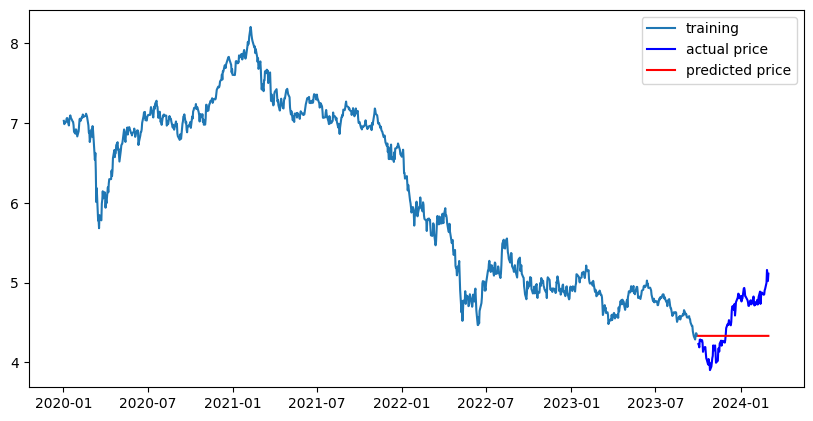

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1382.7119534783756
MAE:  30.55084048179372
RMSE:  37.1848349932923
MAPE: 29.03%


In [60]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming `df` is your DataFrame and 'Close' is the column with stock prices
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predicting and inverse transforming the predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


Epoch 1/50
24/24 [==============================] - 4s 44ms/step - loss: 0.0206 - val_loss: 0.0018
Epoch 2/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 1.3874e-05
Epoch 3/50
24/24 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 2.3061e-04
Epoch 4/50
24/24 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 1.1171e-05
Epoch 5/50
24/24 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 1.3750e-05
Epoch 6/50
24/24 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 3.4402e-05
Epoch 7/50
24/24 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 1.7758e-05
Epoch 8/50
24/24 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 1.5306e-05
Epoch 9/50
24/24 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 6.9895e-05
Epoch 10/50
24/24 [==============================] - 0s 16ms/step - loss: 0.0

In [61]:
true_values_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE
mape = calculate_mape(true_values_rescaled, predicted_stock_price)
print(f"MAPE: {mape}%")


MAPE: 9.366343698281119%


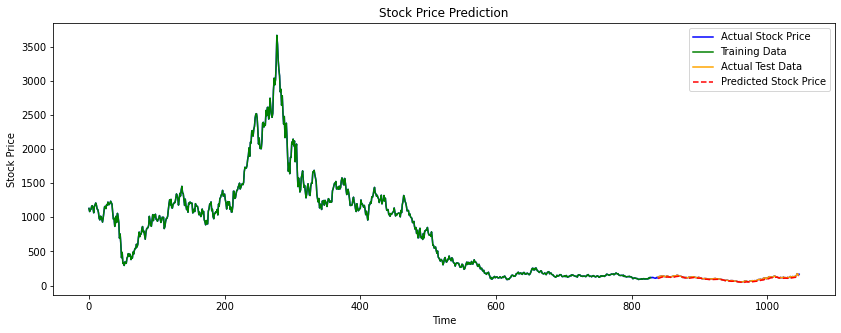

In [62]:
import matplotlib.pyplot as plt

# Assuming 'df' and 'Close' as before, and that 'true_values_rescaled' and 'predicted_stock_price'
# have been correctly calculated

plt.figure(figsize=(14, 5))
plt.plot(df['Close'].reset_index(drop=True), color='blue', label='Actual Stock Price')

# Assuming 'train_size' is the number of samples in your training set
# And 'seq_length' was used in preparing sequences for the LSTM
# Adjust the train and test data plots to align with the prepared data
plt.plot(scaler.inverse_transform(X_train[:, 0]), color='green', label='Training Data')

# The predicted_stock_price might need to be aligned with the test data's actual indices
# Let's assume test_data_range needs to be adjusted for seq_length and any additional offsets
adjusted_test_data_range = np.arange(train_size + seq_length, train_size + seq_length + len(predicted_stock_price))

plt.plot(adjusted_test_data_range, true_values_rescaled, color='orange', label='Actual Test Data')
plt.plot(adjusted_test_data_range, predicted_stock_price, color='red', linestyle='--', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
